# Sử dụng deep feature để xây dựng một bộ phân loại hình ảnh

In [1]:
import sklearn, pandas
import numpy as np

# Load tập dữ liệu phân tích hình ảnh phổ biến

Chúng ta sẽ sử dụng một tập dữ liệu đánh giá xếp hạng phổ biến là CIFAR-10.

(Chúng tôi đã giảm dữ liệu xuống còn 4 hạng mục = {'cat','bird','automobile','dog'}.)

Tập dữ liệu này đã được chia thành training set và test set. 

In [2]:
# image_train_data.csv: https://1drv.ms/u/s!AibrDR5609kdj2XIpDzPklgt_l4M?e=aNi5In
# image_test_data.csv: https://1drv.ms/u/s!AibrDR5609kdj2bvyGnMmQvKEpuX?e=BQ6faL
image_train = pandas.read_csv('image_train_data.csv')
image_test = pandas.read_csv('image_test_data.csv')

# Khám phá dữ liệu hình ảnh

In [4]:
#graphlab.canvas.set_target('ipynb')
import matplotlib.pyplot as plt
%matplotlib inline
def show_image(image_data, dimension=(32, 32, 3)):
    image = np.reshape(image_data, dimension)
    plt.axis('off')
    plt.imshow(image)       
    
def show_images(images, cols=3):
    rows = len(images) // cols + ( 0 if len(images) % cols == 0 else 1)
    fig = plt.figure(figsize=(cols, rows))
    for i, img_data in enumerate(images):
        #i_row, i_col = i % cols, i // cols
        fig.add_subplot(rows, cols, i+1)
        show_image(img_data)

In [5]:
#[it for it in image_train['image_array'][:10].values]
import itertools, io
def convert_img(img): 
    stringbuf = io.StringIO(img[1:-1])
    array = np.loadtxt(stringbuf, dtype=np.uint8)
    stringbuf.close()
    #print(np.shape(array))
    return array
def variable_length_to_2d(series):
    return np.array(list(itertools.zip_longest(*series.values, fillvalue=0))).T
image_train['image_np'] = image_train['image_array'].map(convert_img)
image_test['image_np'] = image_test['image_array'].map(convert_img)
#image_train['image_np'] = image_np.tolist()
print(np.shape(image_train['image_np'][0]), np.shape(image_test['image_np'][0]))

(3072,) (3072,)


# Huấn luyện một bộ phân loại trên các điểm ảnh thô (raw image pixel)

Trước tiên chúng ta sẽ bắt đầu bằng việc huấn luyện một bộ phân loại chỉ dựa trên các điểm ảnh thô.

bird


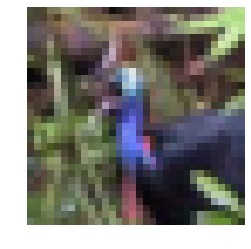

In [ ]:
show_image(image_train['image_np'].values[0])
print(image_train['label'][0])

In [6]:
#raw_pixel_model = graphlab.logistic_classifier.create(image_train,target='label',
#                                              features=['image_array'])
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

raw_pixel_model = LogisticRegression()
label_encoder = LabelEncoder()

train_labels = label_encoder.fit_transform(image_train['label'])
train_data = variable_length_to_2d(image_train['image_np'])
print(np.shape(train_data), np.shape(train_labels))
raw_pixel_model.fit(train_data, train_labels)

(2005, 3072) (2005,)


/Users/ngohongthai/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

# Đưa ra dự đoán với mô hình đơn giản dựa trên các điểm ảnh thô

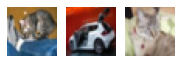

In [7]:
show_images(image_test[0:3]['image_np'].values)

In [8]:
image_test[0:3]['label']

0           cat
1    automobile
2           cat
Name: label, dtype: object

In [9]:
test_data = variable_length_to_2d(image_test['image_np'])
# force the test_data to the features size of train_data
#features_size = np.shape(train_data)[1]
#test_size = np.shape(test_data)[1]
#test_data = np.pad(test_data, ((0, 0), (0, features_size-test_size)), mode='constant', constant_values=0)[:, :features_size]
test_preds = raw_pixel_model.predict(test_data[0:3])
label_encoder.inverse_transform(test_preds)

array(['bird', 'dog', 'dog'], dtype=object)

Mô hình đưa ra các dự đoán sai cho cả 3 hình.

# Đánh giá mô hình điểm ảnh thô trên dữ liệu kiểm tra

In [10]:
#raw_pixel_model.evaluate(image_test)
from sklearn.metrics import confusion_matrix, precision_score
test_preds = raw_pixel_model.predict(test_data)
test_labels = label_encoder.transform(image_test['label'])
print(label_encoder.classes_)
print(confusion_matrix(test_labels, test_preds))
print(precision_score(test_labels, test_preds, average="micro"))

['automobile' 'bird' 'cat' 'dog']
[[629 131 104 136]
 [104 492 180 224]
 [127 216 341 316]
 [ 86 255 264 395]]
0.46425


Độ chính xác của mô hình này khá thấp, chỉ khoảng 46%.

# Cải thiện mô hình với các deep feature

Chúng ta chỉ có 2005 điểm dữ liệu nên không thể huấn luyện một mạng nơ-ron sâu hiệu quả với ít dữ liệu. Thay vào đó, hãy sử dụng transfer learning (học truyền tải): bằng cách dùng các deep feature đã huấn luyện trong tập dữ liệu ImageNet đầy đủ, chúng ta có thể huấn luyện một mô hình đơn giản trên tập dữ liệu nhỏ này.

In [11]:
len(image_train)

2005

## Tính các deep feature cho hình ảnh

2 dòng dưới đây cho phép tính các deep feature. Việc tính toán này sẽ tốn một chút thời gian nên chúng tôi đã tính và lưu kết quả như ở cột trong dữ liệu mà bạn load.

(Lưu ý: nếu bạn muốn tính các deep feature như vậy và có GPU trên máy, bạn nên dùng GPU cho phép Graphlab Create, sẽ giúp tác vụ này nhanh hơn đáng kể).

In [12]:
#deep_learning_model = graphlab.load_model('http://s3.amazonaws.com/GraphLab-Datasets/deeplearning/imagenet_model_iter45')
#image_train['deep_features'] = deep_learning_model.extract_features(image_train)

Như bạn thấy, cột deep_features chứa các deep feature đã tính trước cho dữ liệu này.

In [13]:
image_train.head()

,id,image,label,deep_features,image_array,image_np
0,24,Height: 32 Width: 32,bird,[0.242872 1.09545 0 0.39363 0 0 11.8949 0 0 0 ...,[73 77 58 71 68 50 77 69 44 120 116 83 125 120...,"[73, 77, 58, 71, 68, 50, 77, 69, 44, 120, 116,..."
1,33,Height: 32 Width: 32,cat,[0.525088 0 0 0 0 0 9.94829 0 0 0 0 0 1.01264 ...,[7 5 8 7 5 8 5 4 6 7 4 7 11 5 9 11 5 9 17 11 1...,"[7, 5, 8, 7, 5, 8, 5, 4, 6, 7, 4, 7, 11, 5, 9,..."
2,36,Height: 32 Width: 32,cat,[0.566016 0 0 0 0 0 9.9972 0 0 0 1.38345 0 0.7...,[169 122 65 131 108 75 193 196 192 218 221 222...,"[169, 122, 65, 131, 108, 75, 193, 196, 192, 21..."
3,70,Height: 32 Width: 32,dog,[1.1298 0 0 0.778194 0 0.758051 9.83053 0 0 0....,[154 179 152 159 183 157 165 189 162 174 199 1...,"[154, 179, 152, 159, 183, 157, 165, 189, 162, ..."
4,90,Height: 32 Width: 32,bird,[1.71787 0 0 0 0 0 9.33936 0 0 0 0 0 0.412137 ...,[216 195 180 201 178 160 210 184 164 212 188 1...,"[216, 195, 180, 201, 178, 160, 210, 184, 164, ..."


#Với các deep feature cho trước, hãy huấn luyện một bộ phân loạ

In [14]:
image_train['deep_features'].values[0]

'[0.242872 1.09545 0 0.39363 0 0 11.8949 0 0 0 0 0 0 0 0 0 0 0.57885 0.495467 2.51413 0 1.51801 0 0 0 0 0 0 0 0 0 0 0 0 0 1.5814 0 0 2.59561 2.70796 0 0 0 0.85099 0 0.720349 0 0 0 0 0 0.270036 0 0 0 0 0.085928 0 0.701023 0 0 0 0 0.0248057 0 0 0.17549 0 0 0 0 0 2.39278 0 0 4.47187 0 1.63583 0 4.41748 0 0 0 0 0 0 0 0 0 0 0 1.41179 0 0 0 0 0 0 0 0 0 0 0.124768 0 0 0.895716 0 0 0.333499 0 0 0.207873 2.54354 0 0 0.184338 0 1.42003 0 0 0 0 0 0 0 0 0 0 0 1.43542 0 0 0 0 0 1.93689 0 0 0 0 0 0.885218 0 0 1.42506 0 0 1.30532 1.31116 0 0 0 0 0 0 2.8661 0 0 0 0 0 0.841856 0 0 0 0 2.39469 0 0 0 2.17862 0 1.20806 0 1.02115 0 0 0 0 1.0027 1.00278 2.88097 0 0 0 0 0 0 0.0444847 11.2869 0 0 0 0 0 0 0 0 0 0 0 0 0 1.25519 0 1.01393 1.10103 0 2.65495 0.0743851 3.38323 0 0 1.33688 0.480166 0.935999 0.130775 0 0 0 2.55289 0 0 1.98796 0 1.81481 0 0.688944 0 0.318657 2.12182 0 0.5624 1.13918 1.94655 3.15611 0 0 1.68452 0 1.21483 1.07752 0.345013 1.23942 0 0 0 0 0 0 0 0 0 0.77367 0 2.06167 0 0 0 0 2.8326 2.5339

In [15]:
def convert_features(img):
    stringbuf = io.StringIO(img[1:-1])
    array = np.loadtxt(stringbuf, dtype=np.float16)
    stringbuf.close()
    return array
image_train['deep_np'] = image_train['deep_features'].map(convert_features)
image_test['deep_np'] = image_test['deep_features'].map(convert_features)
deep_features_model = LogisticRegression()

train_data = variable_length_to_2d(image_train['deep_np'])
print(np.shape(train_data), np.shape(train_labels))
deep_features_model.fit(train_data, train_labels)
#deep_features_model = graphlab.logistic_classifier.create(image_train,
#                                                         features=['deep_features'],
#                                                         target='label')

(2005, 4096) (2005,)


/Users/ngohongthai/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

# Áp dụng mô hình deep feature cho một vài hình đầu tiên của test set

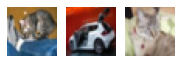

In [16]:
show_images(image_test[0:3]['image_np'].values)

In [17]:
test_data = variable_length_to_2d(image_test['deep_np'])
label_encoder.inverse_transform(deep_features_model.predict(test_data[0:3]))

array(['cat', 'automobile', 'cat'], dtype=object)

Bộ phân loại với các deep feature nhận được tất cả các hình đúng!

# Tính độ chính xác test_data của deep_features_model

Như bạn thấy, deep feature cho chúng ta độ chính xác cao hơn đáng kể (khoảng 78%).

In [18]:
test_preds = deep_features_model.predict(test_data)
test_labels = label_encoder.transform(image_test['label'])
print(label_encoder.classes_)
print(confusion_matrix(test_labels, test_preds))
print(precision_score(test_labels, test_preds, average="micro"))

['automobile' 'bird' 'cat' 'dog']
[[971  14   9   6]
 [  9 808 130  53]
 [ 17  80 681 222]
 [  3  60 213 724]]
0.796
